In [3]:
from load_data import load_data_singer, load_data_album, load_data_era, plot_tsne
from transformers import AutoTokenizer, AutoModel, pipeline, BertForSequenceClassification
import pandas as pd

In [11]:
# load the data of all classification goals
train_df_a, test_df_a = load_data_album()
train_df_e, test_df_e = load_data_era()
train_df_s, test_df_s = load_data_singer()

albums = sorted(train_df_a['album'].unique())

# t-SNE plots

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
extractor = pipeline("feature-extraction", batch_size=1024, model=model, tokenizer=tokenizer)

In [9]:
def extract_embeddings(train_df, token):
    """Encodes lyrics and for each sentence, returns the vector corresponding to the given token.

    Arguments:
        lyrics (list[str]): The sentences to feed into the model.
        token (str): The token to extract the embedding for.

    Returns:
        A list of vectors, one vector for each input sentence, corresponding to the contextual embedding
        of `token` within `sentence`. (This can be either a PyTorch tensor or a NumPy array.)
    """

    output = []
    for _, row in train_df.iterrows():
        input_ids = tokenizer(row["lyrics"])["input_ids"]
        token_pos = 0
        for i, id in enumerate(input_ids):
            if tokenizer.convert_ids_to_tokens(id) == token.lower():
                token_pos = i
        output.append(extractor(row["lyrics"], return_tensors=True, truncation=True)[0,token_pos,:]) 
        # we use truncation to handle one song being longer than the maximum number of tokens (743 > 512)
        # output.append(extractor(row["lyrics"], return_tensors="pt", truncation=True)[0,token_pos,:])
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.000s...


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\nikos\anaconda3\envs\liu-text-mining\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\nikos\anaconda3\envs\liu-text-mining\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\nikos\anaconda3\envs\liu-text-mining\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  wa

[t-SNE] Computed neighbors for 75 samples in 0.844s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 2.654743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.749996
[t-SNE] KL divergence after 850 iterations: 0.287281


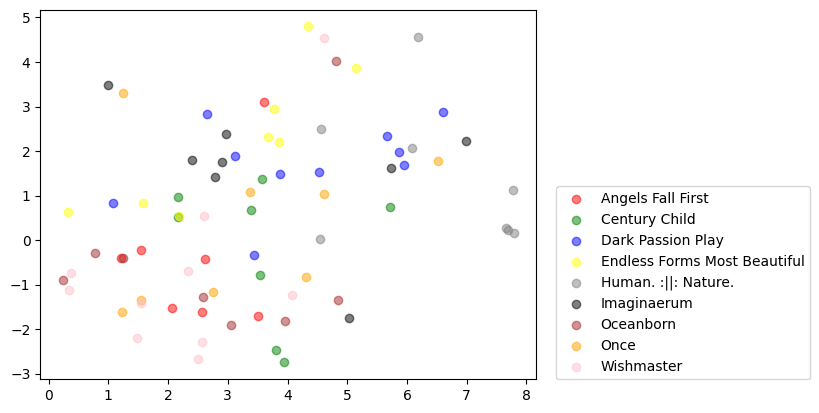

In [10]:
lyric_vectors_a = extract_embeddings(train_df_a,"[CLS]")
lyric_vectors_np_a = [tensor.numpy() for tensor in lyric_vectors_a] # convert to numpy array to use for scikit_learn algos
plot_tsne(lyric_vectors_a, train_df_a["album"],  perplexity=30.0, n_iter=2000)

We can see that it is hard to spot real clusters and decision boundaries between the albums in this T-SNE dimensionality reduction. Some albums produce clusters like the Human :||: Nature album where a few songs show as very similar. Entries from Dark Passion Play also seem to be kind of similar. Other albums show very varied results. This could suggest that classifying albums is a hard task, as the difference between albums is not that big or easy to grasp for models.

We have to consider though that this plot is limited, as information gets lost in the dimensionality reduction and that every iteration of the plot may look quite different.

[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.000s...
[t-SNE] Computed neighbors for 75 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 2.631783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.318340
[t-SNE] KL divergence after 900 iterations: 0.270819


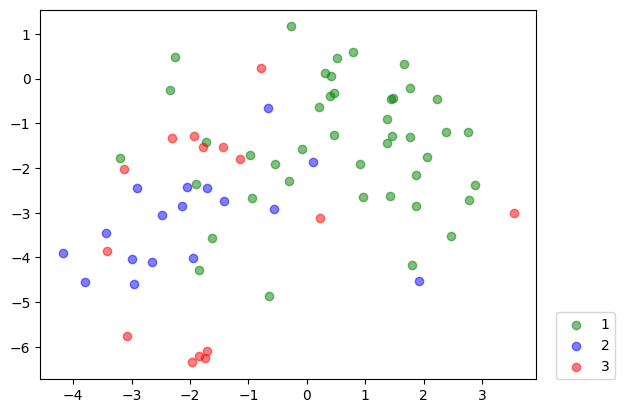

In [12]:
lyric_vectors_s = extract_embeddings(train_df_s,"[CLS]")
lyric_vectors_np_s = [tensor.numpy() for tensor in lyric_vectors_s] # convert to numpy array to use for scikit_learn algos
plot_tsne(lyric_vectors_s, train_df_s["singer_id"],  perplexity=30.0, n_iter=2000)

[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.000s...
[t-SNE] Computed neighbors for 75 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 2.608379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.356567
[t-SNE] KL divergence after 700 iterations: 0.233531


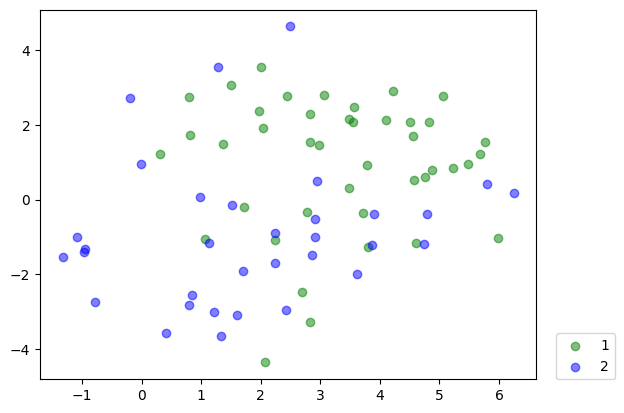

In [13]:
lyric_vectors_e = extract_embeddings(train_df_e,"[CLS]")
lyric_vectors_np_e = [tensor.numpy() for tensor in lyric_vectors_e] # convert to numpy array to use for scikit_learn algos
plot_tsne(lyric_vectors_e, train_df_e["era_id"],  perplexity=30.0, n_iter=2000)

# Bar plot of album frequency

Text(0.5, 1.0, 'Songs with lyrics per album')

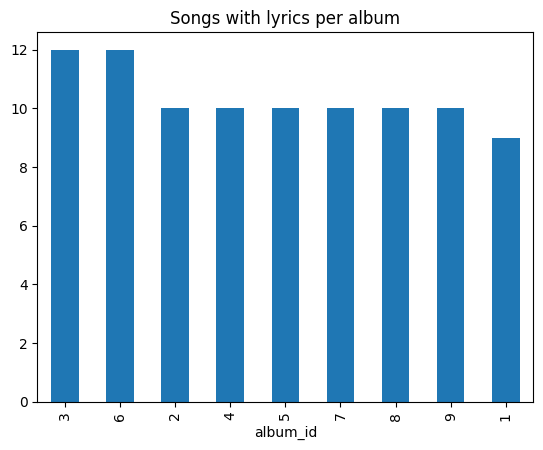

In [2]:
df = pd.read_csv("nightwish_lyrics.csv")
plot = df['album_id'].value_counts().plot(kind='bar')
plot.set_title("Songs with lyrics per album")